# Pharma sales Time Series predictions: ARMA, SARIMA, SARIMAX, VAR

The database used is from kaggle: https://www.kaggle.com/datasets/milanzdravkovic/pharma-sales-data

It shows daily sales of drugs in 8 ATC categories, by a single pharmacy store over 6 years (last year incomplete).

In [1]:
!pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("milanzdravkovic/pharma-sales-data")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\drgui\.cache\kagglehub\datasets\milanzdravkovic\pharma-sales-data\versions\1


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm
!pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import itertools
import warnings
warnings.filterwarnings("ignore")

In [129]:
csv_path = os.path.join(path, "salesdaily.csv")
df = pd.read_csv(csv_path)
print(df.head())
print(df.shape)

      datum  M01AB  M01AE  N02BA  N02BE  N05B  N05C   R03  R06  Year  Month  \
0  1/2/2014    0.0   3.67    3.4  32.40   7.0   0.0   0.0  2.0  2014      1   
1  1/3/2014    8.0   4.00    4.4  50.60  16.0   0.0  20.0  4.0  2014      1   
2  1/4/2014    2.0   1.00    6.5  61.85  10.0   0.0   9.0  1.0  2014      1   
3  1/5/2014    4.0   3.00    7.0  41.10   8.0   0.0   3.0  0.0  2014      1   
4  1/6/2014    5.0   1.00    4.5  21.70  16.0   2.0   6.0  2.0  2014      1   

   Hour Weekday Name  
0   248     Thursday  
1   276       Friday  
2   276     Saturday  
3   276       Sunday  
4   276       Monday  
(2106, 13)


Let's start by looking at the **daily sales of one drug**, for instance N05B - Psycholeptics drugs, Anxiolytic drugs.

In [130]:
# Convert date
df['datum'] = pd.to_datetime(df['datum'])

# Choose a single drug time series
drug_col = "N05B"   
ts = df.set_index('datum')[drug_col].sort_index()

print("Number of time points:", len(ts))
ts.head()

Number of time points: 2106


datum
2014-01-02     7.0
2014-01-03    16.0
2014-01-04    10.0
2014-01-05     8.0
2014-01-06    16.0
Name: N05B, dtype: float64

Do we have **missing values**? If yes, we can forward fill (fill in missing values by carrying forward the last observed non-missing value from the dataset).

In [131]:
ts = ts.to_frame()
print(ts['N05B'].isna().sum())

0


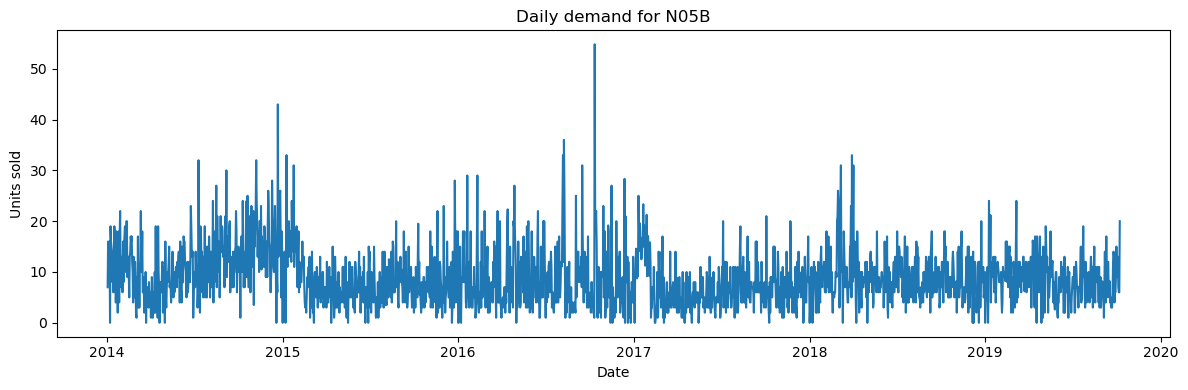

Final number of points: 2106


In [8]:
ts.name = "demand"

plt.figure(figsize=(12,4))
plt.plot(ts.index, ts.values)
plt.title(f"Daily demand for {drug_col}")
plt.xlabel("Date")
plt.ylabel("Units sold")
plt.tight_layout()
plt.show()

print("Final number of points:", len(ts))

The seasonality patterns for months or weeks can be explored using boxplots.

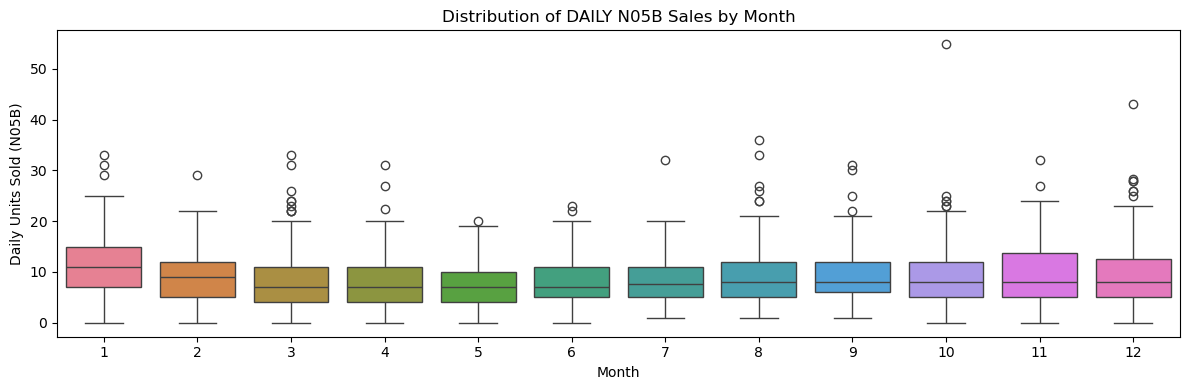

In [133]:
import seaborn as sns

# Create a Month column from the index
ts['Month'] = ts.index.month

# (Optional) ensure proper month ordering
ts['Month'] = pd.Categorical(
    ts['Month'],
    categories=[1,2,3,4,5,6,7,8,9,10,11,12],
    ordered=True
)

# Plot DAILY sales grouped by month
plt.figure(figsize=(12, 4))
sns.boxplot(data=ts, x='Month', y='N05B', palette='husl')

plt.title("Distribution of DAILY N05B Sales by Month")
plt.xlabel("Month")
plt.ylabel("Daily Units Sold (N05B)")
plt.tight_layout()
plt.show()

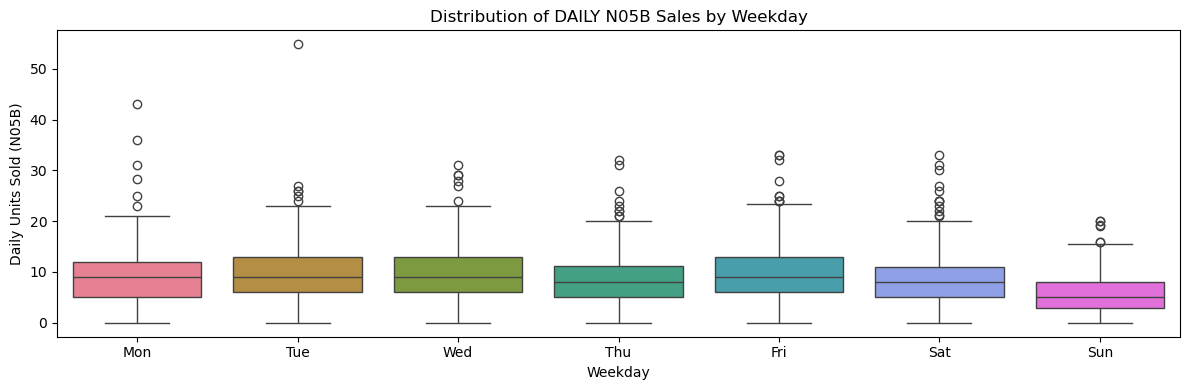

In [134]:
ts['Weekday'] = ts.index.weekday

# Map numbers to weekday names
weekday_map = {
    0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu',
    4: 'Fri', 5: 'Sat', 6: 'Sun'
}
ts['Weekday'] = ts['Weekday'].map(weekday_map)

# Set order (optional but nicer)
weekday_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Plot boxplot grouped by weekday
plt.figure(figsize=(12, 4))
sns.boxplot(data=ts, x='Weekday', y='N05B', order=weekday_order, palette='husl')

plt.title("Distribution of DAILY N05B Sales by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Daily Units Sold (N05B)")
plt.tight_layout()
plt.show()

Rolling window means can also be useful for discovering seasonality patterns.

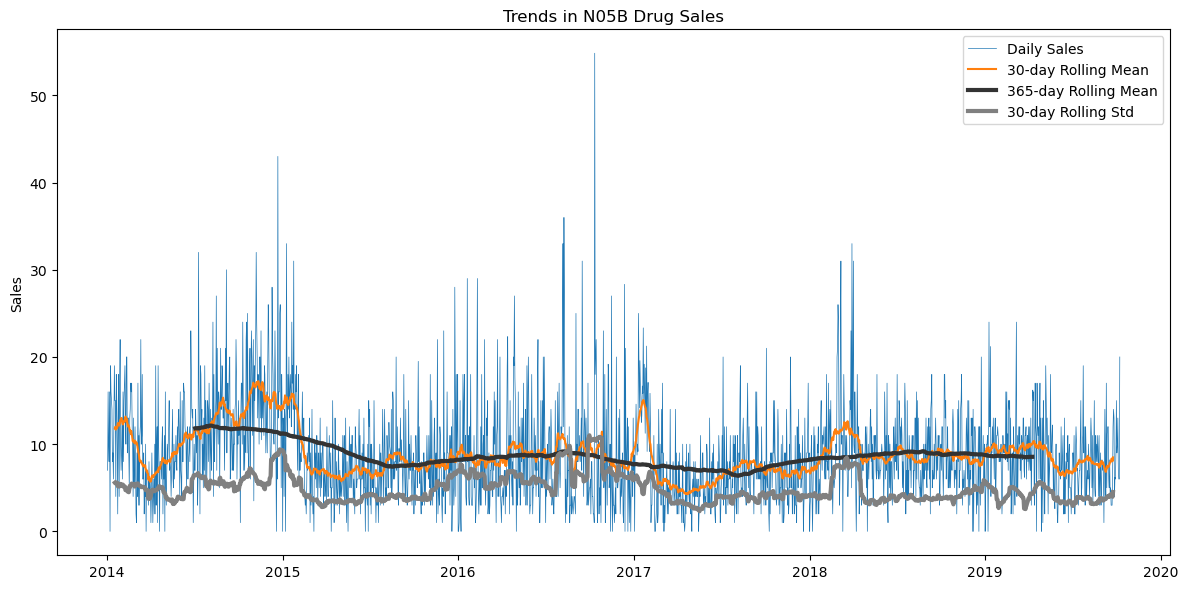

In [123]:
import math

# Select only N05B
drug = 'N05B'

# Compute rolling statistics
ts_365d = ts[drug].rolling(window=365, center=True).mean()
ts_30d  = ts[drug].rolling(window=30, center=True).mean()
ts_std  = ts[drug].rolling(window=30, center=True).std()

# Create single plot
plt.figure(figsize=(12,6))

plt.plot(ts[drug], linewidth=0.5, label='Daily Sales')
plt.plot(ts_30d, label='30-day Rolling Mean')
plt.plot(ts_365d, color='0.2', linewidth=3, label='365-day Rolling Mean')
plt.plot(ts_std, color='0.5', linewidth=3, label='30-day Rolling Std')

plt.ylabel('Sales')
plt.title('Trends in N05B Drug Sales')
plt.legend()
plt.tight_layout()
plt.show()

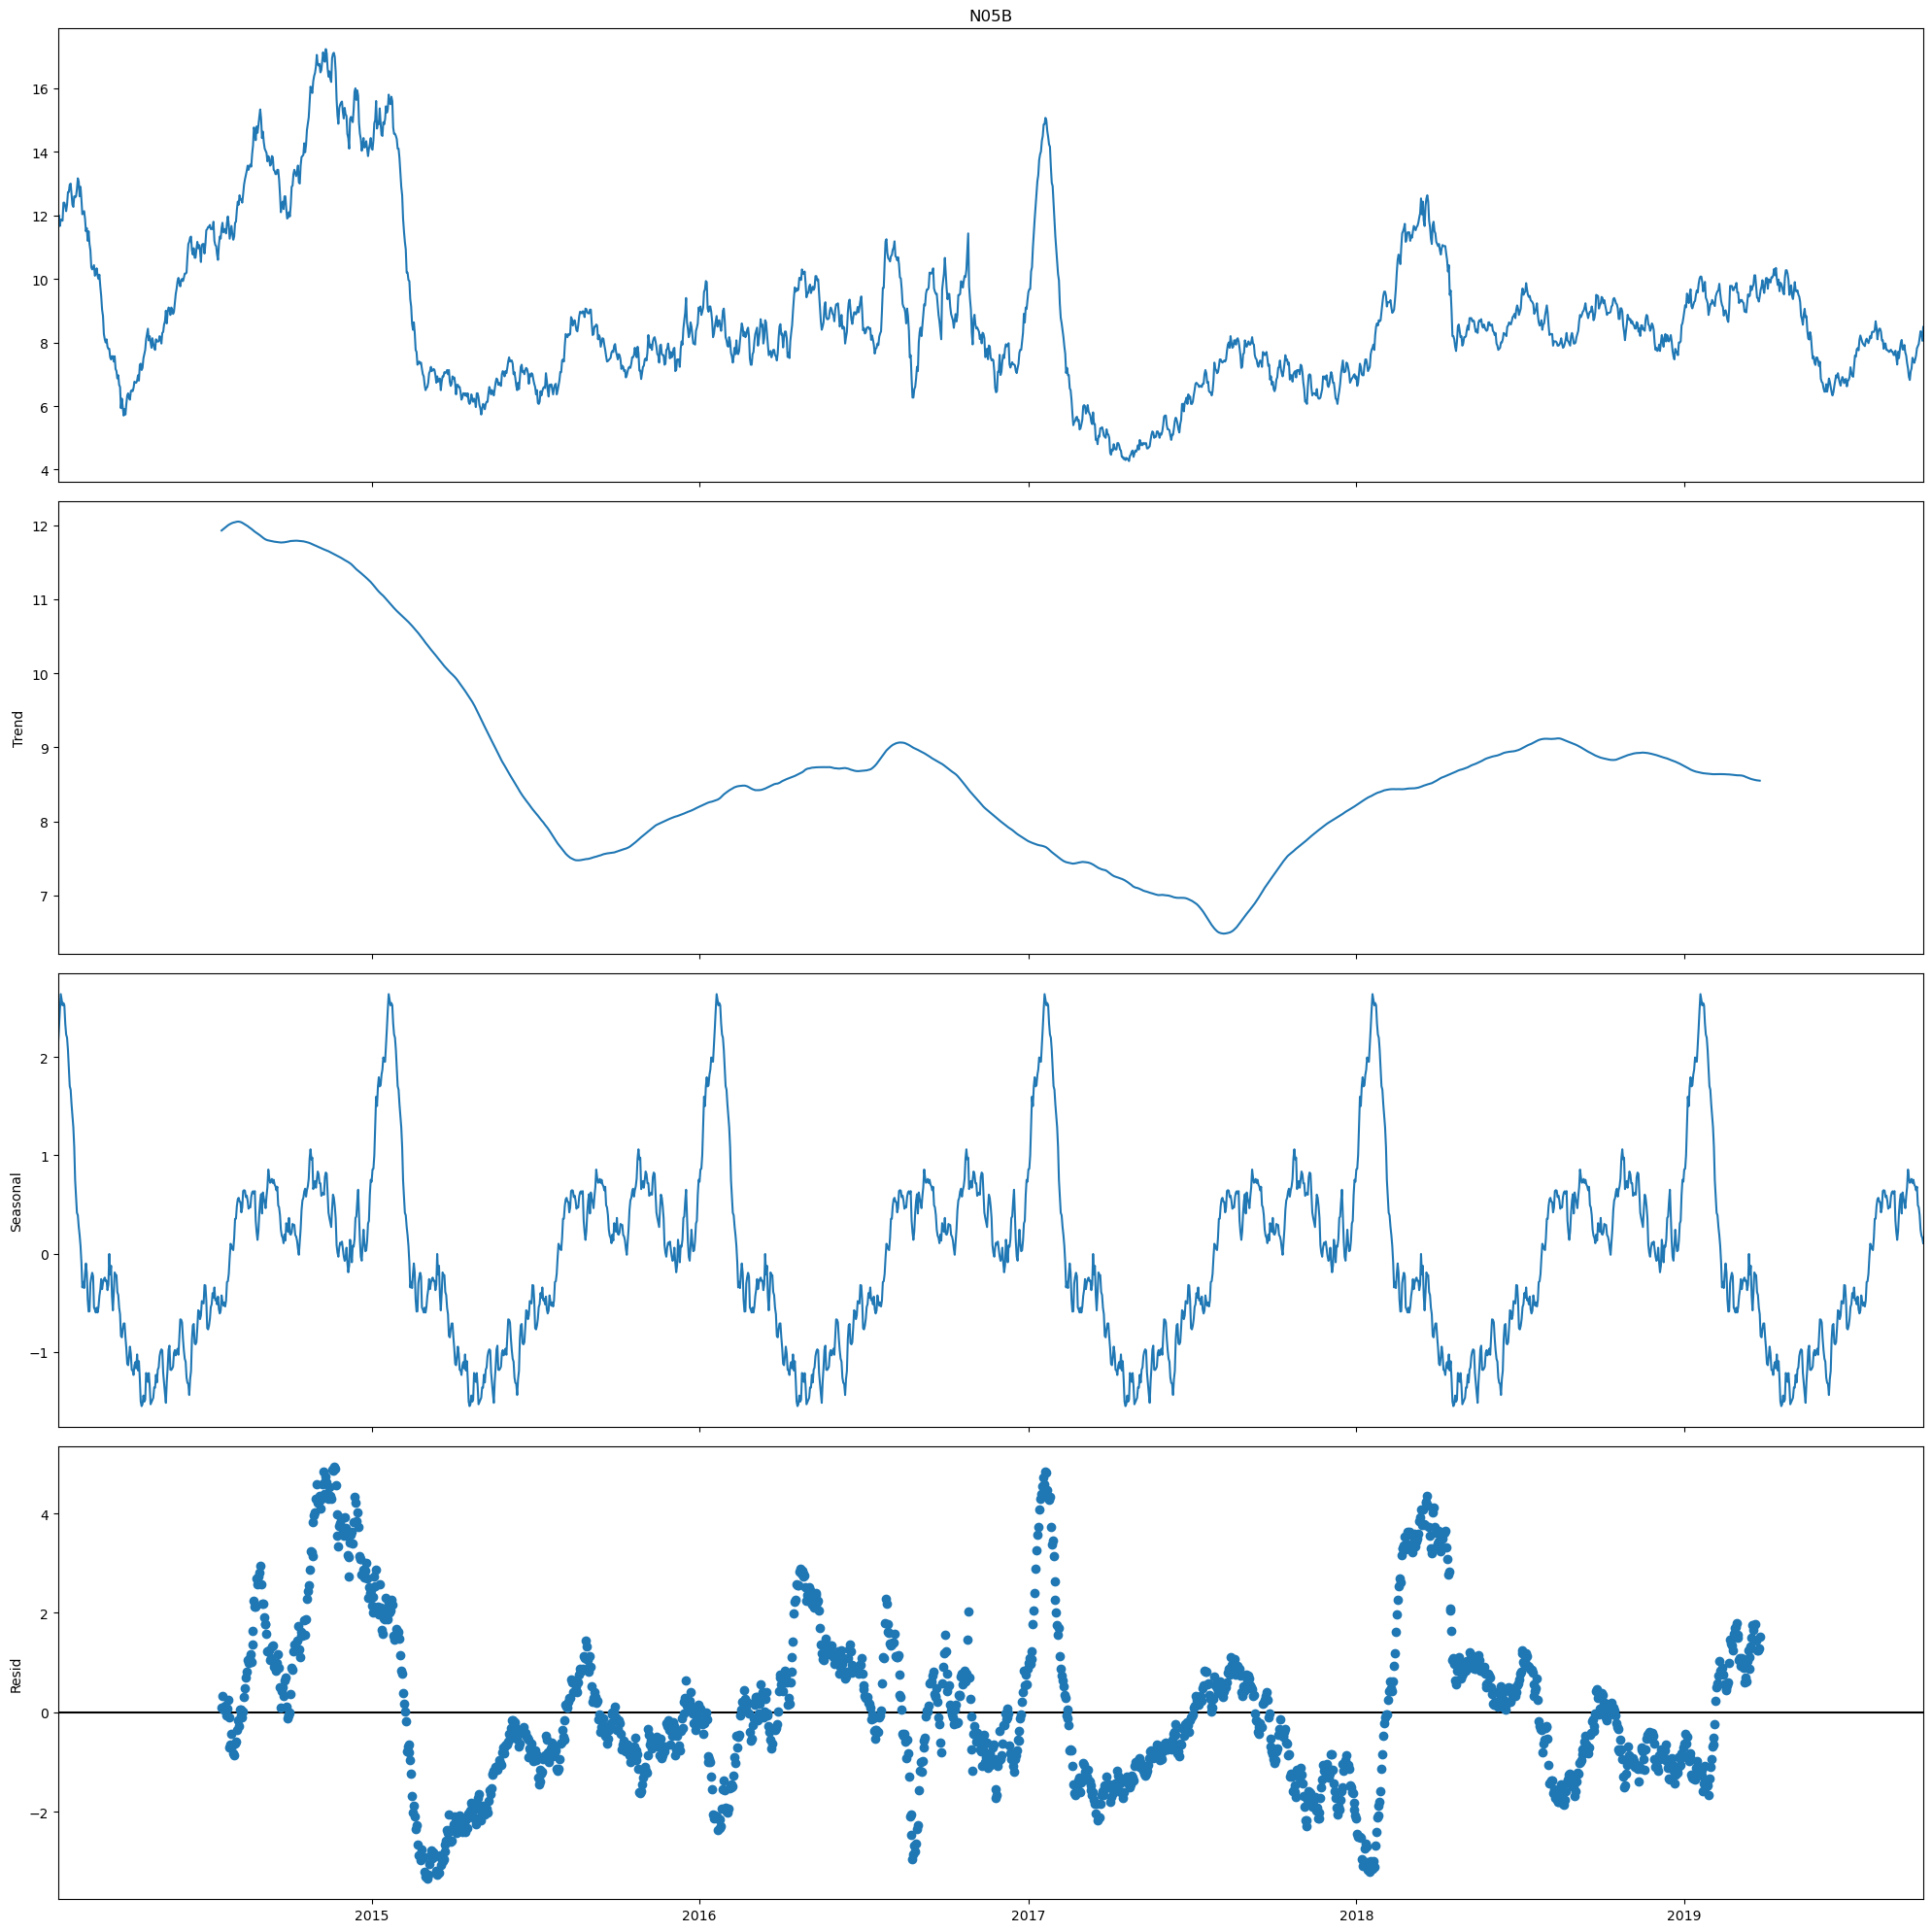

In [127]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts[drug].rolling(30, center=True).mean().dropna(), period=365, filt=None)
plt.rcParams["figure.figsize"] = (20,20)
result.plot()
plt.show()

It seems there is some weekly and monthly seasonal pattern.

We can **seperate the data** in a **train set** and a **test set** to evaluate our prediction models.

Train points: 1926
Test points : 180


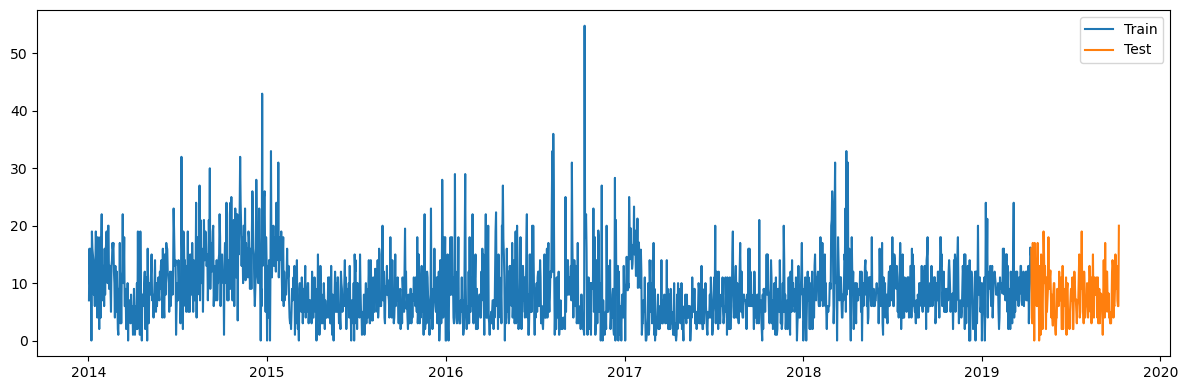

In [135]:
ts = ts.drop(['Month', 'Weekday'], axis=1)

TEST_HORIZON = 180   # e.g. last 180 days as test

ts_train = ts.iloc[:-TEST_HORIZON]
ts_test  = ts.iloc[-TEST_HORIZON:]

print("Train points:", len(ts_train))
print("Test points :", len(ts_test))

plt.figure(figsize=(12,4))
plt.plot(ts_train.index, ts_train.values, label="Train")
plt.plot(ts_test.index, ts_test.values, label="Test")
plt.legend()
plt.tight_layout()
plt.show()

A **stationary time series** is one whose statistical properties do not change over time. It has a constant mean, variance, and autocorrelation, and these properties are independent of time.

In [21]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(ts_train)
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Number of lags used:", result[2])
print("Number of observations:", result[3])
print("Critical Values:", result[4])

ADF Statistic: -4.532365169444581
p-value: 0.00017179046278360384
Number of lags used: 26
Number of observations: 1899
Critical Values: {'1%': np.float64(-3.4337982155955413), '5%': np.float64(-2.8630631915206006), '10%': np.float64(-2.5675808895205785)}


With a large and negative ADF statistic and a **p-value much smaller than 0.05**, we can reject the null hypothesis and consider the series as **stationary**. 

We don't need differencing.

Let's look at the **ACF and PACF plots**.

<Figure size 1000x400 with 0 Axes>

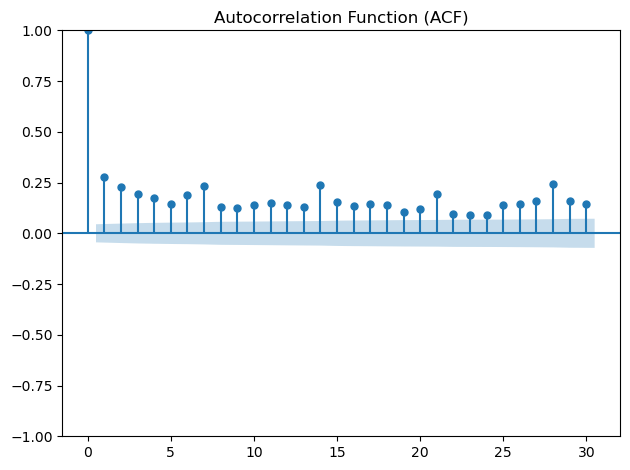

In [22]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(10, 4))
plot_acf(ts_train, lags=30)   # choose number of lags (50 works for daily data; fewer for monthly)
plt.title("Autocorrelation Function (ACF)")
plt.tight_layout()
plt.show()

<Figure size 1000x400 with 0 Axes>

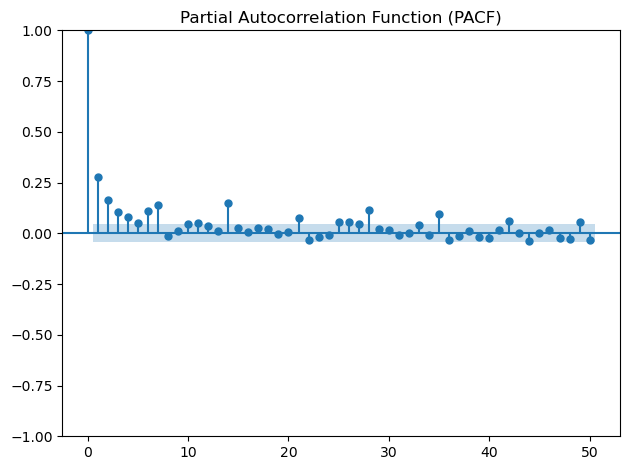

In [23]:
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(10, 4))
plot_pacf(ts_train, lags=50, method='ywm')  # 'ywm' is a stable estimator
plt.title("Partial Autocorrelation Function (PACF)")
plt.tight_layout()
plt.show()

In a **moving average process** (MA(q)), the current value depends linearly on the mean of the series, the current error term, and past error terms.

In an **autoregressive process**, the variable depends linearly on its own previous values, it is a regression of the variable against itself. It is noted AR(p) where p is the order which determines the number of past values that affect the present value. 

In the **Autocorrelation Function (ACF) plot**, we don't observe a lag at which the coefficients abruptly become nonsignificant. This means that we do not have a moving average process.

The **Partial Autocorrelation Function (PACF) plot** can be used to determine the order of a stationary autoregressive process, if the coefficients become abruptly non-significant after lag p. Partial autocorrelation measures the correlation between lagged values in a time series when we remove the influence of correlated lagged values in between.

But here both the ACF and PACF plots exhibit a **slowly decaying pattern** and a **sinusoidal pattern**. There is no order for the MA(q) or AR(p) process that can be inferred.

It could be a combination of both an AR(p) process and an MA(q) process: an **autoregressive moving average (ARMA) process**, or **ARMA(p,q)**. The order p determines the number of past values that affect the present value and the order q determines the number of past error terms that affect the present value. 

We will arbitrarily allow the values of p and q to vary from 0 to 3 and create a list of all possible combinations of (p,q).

We’ll run ARMA(p,q) models for each combination, and compare them using the **Akaike information criterion (AIC)**, that quantifies the relative amount of information lost by the model. The less information lost, the lower the AIC value and the better the model. 

In [24]:
from itertools import product
ps = range(0, 4, 1)
qs = range(0, 4, 1)
order_list = list(product(ps, qs))
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX
def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) ->pd.DataFrame:
    results = []
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], 0, order[1]),simple_differencing=False).fit(disp=False)
        except:
            continue
        aic = model.aic
        results.append([order, aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
#Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC',ascending=True).reset_index(drop=True)
    return result_df
result_df = optimize_ARMA(ts_train, order_list)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 1)",11882.571722
1,"(1, 3)",11883.829510
2,"(2, 1)",11885.520608
3,"(1, 2)",11888.057337
4,"(3, 2)",11889.463583
5,"(2, 3)",11892.055546
6,"(3, 3)",11897.945341
7,"(2, 2)",11898.660172
8,"(1, 1)",11907.022188
9,"(3, 0)",12212.227878


Here the model **ARMA(3,1)** has the lowest AIC.

In [25]:
best_order = result_df.loc[0, '(p,q)']
p, q = best_order
model = SARIMAX(ts_train, order=(p, 0, q), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid
print("Best ARMA model:", best_order)
print(model_fit.summary())

Best ARMA model: (3, 1)
                               SARIMAX Results                                
Dep. Variable:                   N05B   No. Observations:                 1926
Model:               SARIMAX(3, 0, 1)   Log Likelihood               -5936.286
Date:                Fri, 12 Dec 2025   AIC                          11882.572
Time:                        21:21:26   BIC                          11910.388
Sample:                    01-02-2014   HQIC                         11892.805
                         - 04-11-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1203      0.023     49.112      0.000       1.076       1.165
ar.L2         -0.0670      0.030     -2.218      0.027      -0.126      -0.008
ar.L3         -0.0536      0

AR(1) = 1.1203 (p < 0.001) suggests very strong persistence in the series. There is a strong autoregressive persistence.

AR(2) and AR(3) add small corrective behavior to the AR(1) persistence.

MA(1) = –0.9545 (p < 0.001) is a strong negative moving-average term and may improve short-horizon forecasting stability.

The residual variance left after modeling is not that high, but unexplained variation remains after fitting the model.

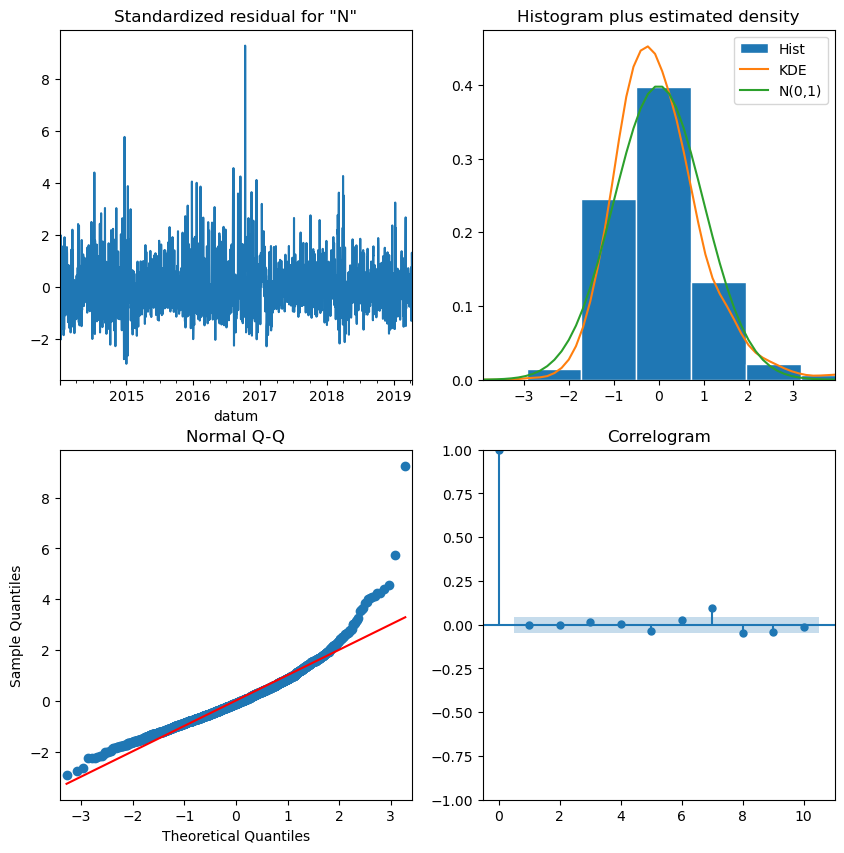

In [26]:
model_fit.plot_diagnostics(figsize=(10, 10));

The top-left plot shows the **residuals across the entire dataset**. The mean seems stable over time, which is indicative of stationarity, just like white noise.
    
The top-right plot shows a **histogram of the residuals**. The shape is suggestive of a normal distribution on this plot, which again indicates that the residuals are close to white noise, as white noise is normally distributed as well.

At the bottom left, on the **Q-Q plot**, a straight line approximately lies on y = x. Therefore, the model’s residuals seem to be overall normally distributed, just like white noise, except at the extremities.
    
Finally, the bottom-right plot shows the **autocorrelation function of our residuals**. There is  a significant peak at lag 0 and some sinusoidal pattern.

The **Ljung-Box test** allows us to quantitatively assess whether our residuals are indeed uncorrelated. Let's use it for 10 lags

In [27]:
from statsmodels.stats.diagnostic import acorr_ljungbox


lb_test = acorr_ljungbox(
    residuals,
    lags=np.arange(1, 11),
    return_df=True
)

# Add a column showing whether p-value < 0.05
lb_test["p< 0.05"] = lb_test["lb_pvalue"] < 0.05

print(lb_test)

      lb_stat  lb_pvalue  p< 0.05
1    0.000011   0.997372    False
2    0.012725   0.993658    False
3    0.562623   0.904933    False
4    0.566373   0.966726    False
5    3.382371   0.641256    False
6    5.029372   0.540052    False
7   22.562904   0.002030     True
8   26.846364   0.000751     True
9   30.070913   0.000427     True
10  30.400293   0.000737     True


The returned p-values are all smaller than 0.05 except for the first six values. This
means that the **residuals are correlated starting at lag 6**. 

Our ARIMA model captures some lag autocorrelation, but not long-lag autocorrelation.

Still, let's see how it fares for now.

We will predict one steps at a time, because we have an ARMA(3,1) model, meaning that there is an MA(1) component.

In [136]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,0,1))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        return pred_ARMA

    elif method == 'SARIMA':
        pred_SARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(
                df[:i],
                order=(3, 0, 3),
                seasonal_order=(3, 1, 3, 7)  # tweak if you’ve found a better seasonal model
            )
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)
        
        return pred_SARIMA


In [29]:
TRAIN_LEN = len(ts_train)
HORIZON = len(ts_test)
WINDOW = 1

pred_mean = rolling_forecast(ts, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(ts, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(ts, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

ts_test.loc[:, 'pred_mean'] = pred_mean
ts_test.loc[:, 'pred_last_value'] = pred_last_value
ts_test.loc[:, 'pred_ARMA'] = pred_ARMA

mse_mean = mean_squared_error(ts_test['N05B'], ts_test['pred_mean'])
mse_last = mean_squared_error(ts_test['N05B'], ts_test['pred_last_value'])
mse_ARMA = mean_squared_error(ts_test['N05B'], ts_test['pred_ARMA'])
print(mse_mean, mse_last, mse_ARMA)

18.066938113229618 30.726444444444446 17.68190887067201


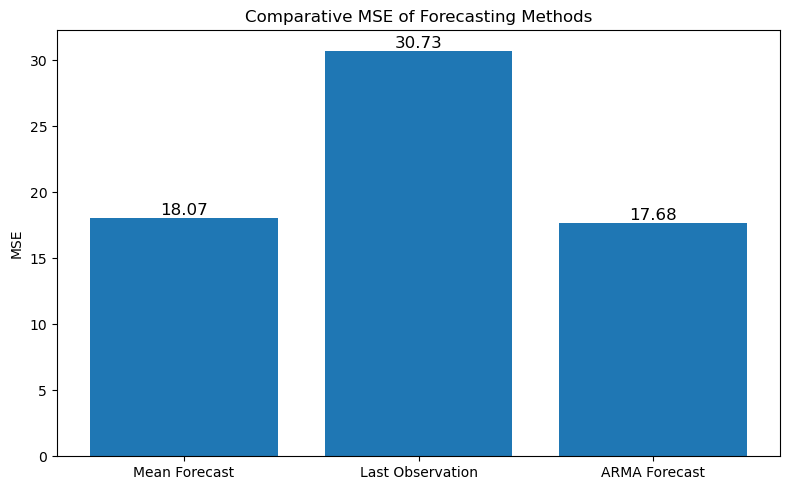

In [30]:
labels = ['Mean Forecast', 'Last Observation', 'ARMA Forecast']
values = [mse_mean, mse_last, mse_ARMA]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, values)

# Add value labels on top of bars
for bar, value in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{value:.2f}",
        ha='center',
        va='bottom',
        fontsize=12
    )

plt.ylabel("MSE")
plt.title("Comparative MSE of Forecasting Methods")
plt.tight_layout()
plt.show()

In [31]:
from sklearn.metrics import mean_absolute_error

mae_mean = mean_absolute_error(ts_test['N05B'], ts_test['pred_mean'])
mae_last = mean_absolute_error(ts_test['N05B'], ts_test['pred_last_value'])
mae_ARMA = mean_absolute_error(ts_test['N05B'], ts_test['pred_ARMA'])

print("MAE (Mean Forecast):", mae_mean)
print("MAE (Last Observation):", mae_last)
print("MAE (ARMA Forecast):", mae_ARMA)

MAE (Mean Forecast): 3.482663659682823
MAE (Last Observation): 4.276666666666666
MAE (ARMA Forecast): 3.357938986404366


On average, the **Mean forecast** fares actually pretty good. It seems there is moderate variation around its central value, but not extremely volatile.

The **Last Observation Forecast** performs the worst. The series is not highly persistent at the daily level.

For now, **ARMA is the best performing model but still off by about 3 units per day**.

We will run a **SARIMA model** to account for seasonality with seasonal period set to 7 and D to 1 as we observed some weekly seasonality.                                      

In [32]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    results = []
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], d, order[1]), seasonal_order=(order[2], D, order[3], s), simple_differencing=False).fit(disp=False)
        except:
            continue
        aic = model.aic
    results.append([order, aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [34]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)
SARIMA_order_list = list(product(ps, qs, Ps, Qs))
d = 0
D = 1
s = 7
SARIMA_result_df = optimize_SARIMA(ts_train, SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 3, 3, 3)",11747.832758


Only one model succeeds. Let's see if we get better results with D=1 and s =30 as we had observed some monthly seasonality.

In [137]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)
SARIMA_order_list = list(product(ps, qs, Ps, Qs))
d = 0
D = 1
s = 30
SARIMA_result_df = optimize_SARIMA(ts_train, SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 3, 3, 3)",11823.799141


Here the model **SARIMA(3,0,3)(3,1,3)** with s=7 has the lowest AIC.

In [35]:
SARIMA_model = SARIMAX(ts_train, order=(3,0,3), seasonal_order=(3,1,3,7), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
residuals = SARIMA_model_fit.resid
print(SARIMA_model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                              N05B   No. Observations:                 1926
Model:             SARIMAX(3, 0, 3)x(3, 1, 3, 7)   Log Likelihood               -5849.960
Date:                           Fri, 12 Dec 2025   AIC                          11725.920
Time:                                   22:09:07   BIC                          11798.194
Sample:                               01-02-2014   HQIC                         11752.513
                                    - 04-11-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0942      0.332     -0.283      0.777      -0.746       0.557
ar.L2          0.7954      0.220      3.613

Residual Variance (sigma² = 25.7993) is quite low, suggesting the model explains a large portion of the daily variation.

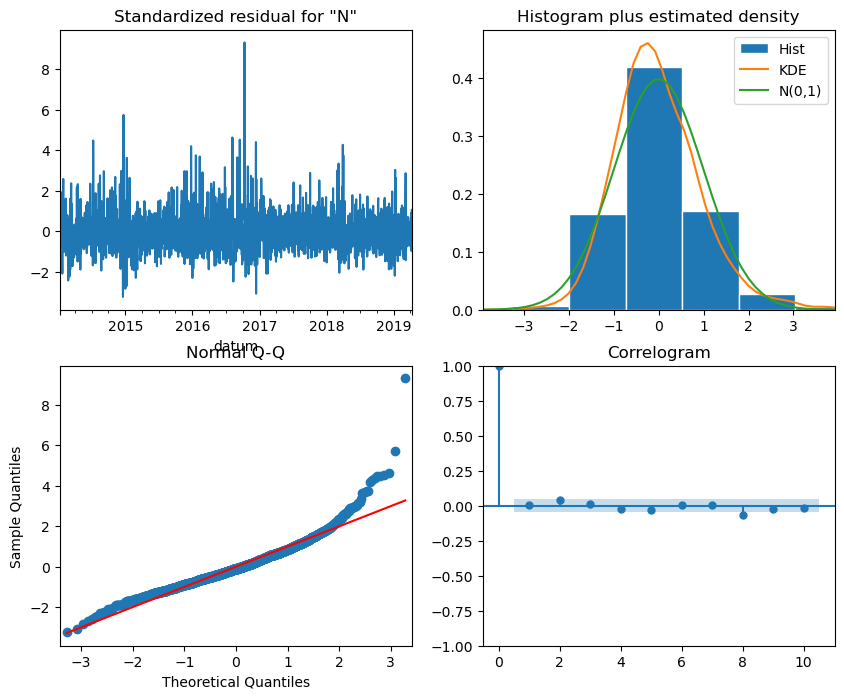

In [36]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [37]:
lb_test = acorr_ljungbox(
    residuals,
    lags=np.arange(1, 11),
    return_df=True
)

# Add a column showing whether p-value < 0.05
lb_test["p< 0.05"] = lb_test["lb_pvalue"] < 0.05

print(lb_test)

      lb_stat  lb_pvalue  p< 0.05
1    0.735299   0.391171    False
2    5.675897   0.058546    False
3    6.551537   0.087652    False
4    7.110708   0.130152    False
5    8.005661   0.155924    False
6    8.388079   0.211028    False
7    8.388967   0.299547    False
8   15.241912   0.054609    False
9   16.232351   0.062185    False
10  16.846400   0.077833    False


It seems that residual autocorrelation has been eliminated.

In [46]:
TRAIN_LEN = len(ts_train)
HORIZON = len(ts_test)
WINDOW = 1

pred_SARIMA = rolling_forecast(ts, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')

ts_test.loc[:, 'pred_SARIMA'] = pred_SARIMA

mse_SARIMA = mean_squared_error(ts_test['N05B'], ts_test['pred_SARIMA'])
print(mse_mean, mse_last, mse_ARMA, mse_SARIMA)

18.066938113229618 30.726444444444446 17.68190887067201 16.19264854141794


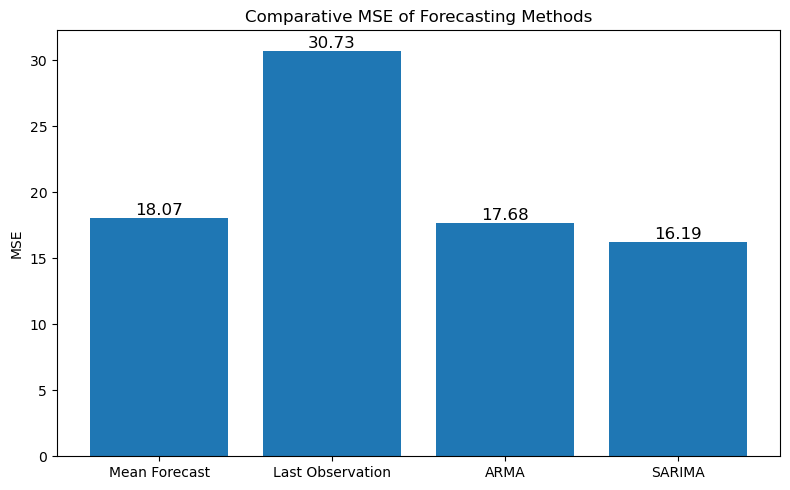

In [48]:
labels = ['Mean Forecast', 'Last Observation', 'ARMA', 'SARIMA']
values = [mse_mean, mse_last, mse_ARMA, mse_SARIMA]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, values)

# Add value labels on top of bars
for bar, value in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{value:.2f}",
        ha='center',
        va='bottom',
        fontsize=12
    )

plt.ylabel("MSE")
plt.title("Comparative MSE of Forecasting Methods")
plt.tight_layout()
plt.show()

Overall, the **SARIMA model fares the best** compared to the previous models.

This dataset seem to be from Serbia. Psycholeptics drugs, Anxiolytic drugs sales may be influenced by the weather. 
So let's use the **precipitation data in mm in Belgrade** from https://www.ecad.eu and use it with the sales data in a **SARIMAX** model.

In [50]:
# Minimum value in the index
min_index_value = ts.index.min()
print(f"Minimum index value: {min_index_value}")

# Maximum value in the index
max_index_value = ts.index.max()
print(f"Maximum index value: {max_index_value}")

Minimum index value: 2014-01-02 00:00:00
Maximum index value: 2019-10-08 00:00:00


In [62]:
dr = pd.read_csv('RR_extracted.csv')
dr['datum'] = pd.to_datetime(dr['DATE'], format='%Y%m%d')
dr = dr[(dr['datum'] >= min_index_value) & (dr['datum'] <= max_index_value)]
ts.index.name = "datum"
dr = ts.join(dr.set_index('datum'), how='left')
dr = dr.drop(['DATE'], axis=1)
dr

,N05B,RR
datum,,
2014-01-02,7.0,0
2014-01-03,16.0,0
2014-01-04,10.0,0
2014-01-05,8.0,4
2014-01-06,16.0,0
...,...,...
2019-10-04,13.0,-9999
2019-10-05,7.0,-9999
2019-10-06,6.0,-9999


There are some missing values, that we forward fill.

In [63]:
dr['RR'] = dr['RR'].replace(-9999, np.nan)
print(dr['RR'].isna().sum())

647


In [65]:
dr=dr.fillna(method='ffill')

In [72]:
target = dr['N05B']
exog = dr[['RR']]
ad_fuller_result = adfuller(target)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -4.779479573481547
p-value: 5.952093543924948e-05


The ADF statistic is a large negative number, and the p-value is smaller than 0.05, so we can reject the null
hypothesis and conclude that the series is stationary.

In [73]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [76]:
p = range(0, 4, 1)
d = 0
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 7

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [77]:
target_train = target[:180]
exog_train = exog[:180]

result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(1, 1, 0, 1)",1038.159957
1,"(1, 3, 0, 1)",1038.168354
2,"(3, 1, 0, 1)",1038.752981
3,"(3, 2, 0, 1)",1039.896928
4,"(1, 1, 1, 1)",1040.011684
...,...,...
251,"(0, 3, 0, 0)",1114.049521
252,"(1, 1, 0, 0)",1115.577988
253,"(1, 0, 0, 0)",1116.549627
254,"(0, 0, 0, 0)",1117.389550


Here the model **SARIMAX(1,0,1)(0,1,1)** has the lowest AIC.

In [78]:
best_model = SARIMAX(target_train, exog_train, order=(1,0,1), seasonal_order=(0,1,1,7), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                              N05B   No. Observations:                  180
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 7)   Log Likelihood                -514.080
Date:                           Fri, 12 Dec 2025   AIC                           1038.160
Time:                                   23:43:28   BIC                           1053.926
Sample:                               01-02-2014   HQIC                          1044.556
                                    - 06-30-2014                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
RR            -0.0020      0.005     -0.420      0.675      -0.011       0.007
ar.L1          0.9766      0.041     23.978

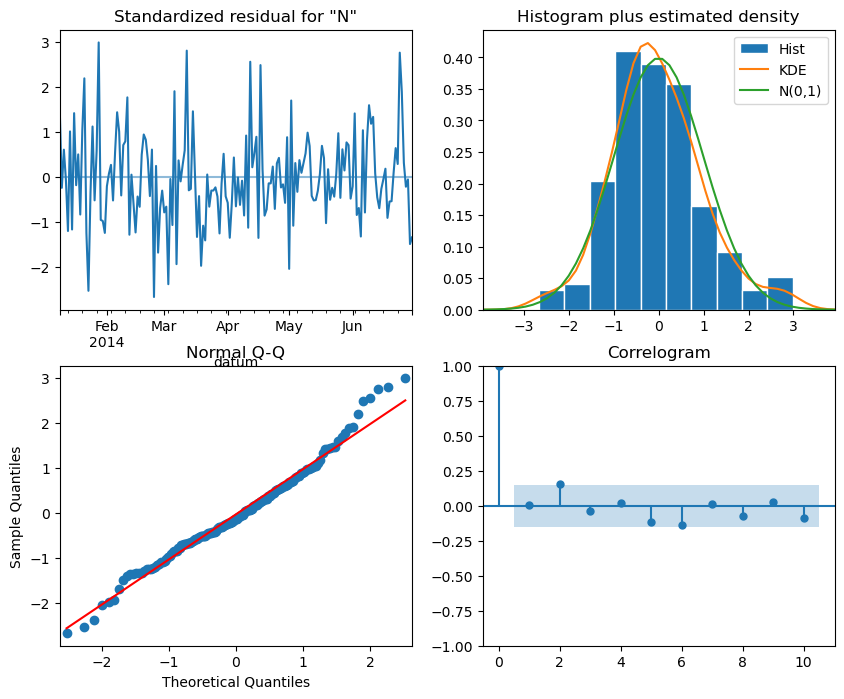

In [79]:
best_model_fit.plot_diagnostics(figsize=(10,8));

In [81]:
lb_test = acorr_ljungbox(
    residuals,
    lags=np.arange(1, 11),
    return_df=True
)

# Add a column showing whether p-value < 0.05
lb_test["p< 0.05"] = lb_test["lb_pvalue"] < 0.05

print(lb_test)

      lb_stat  lb_pvalue  p< 0.05
1    2.558961   0.109671    False
2   12.714745   0.001734     True
3   14.544915   0.002250     True
4   15.831086   0.003254     True
5   15.955380   0.006973     True
6   16.182440   0.012808     True
7   16.191504   0.023423     True
8   16.208247   0.039495     True
9   16.209681   0.062630    False
10  16.605618   0.083559    False


It seems the model does not fully capture the autocorrelation structure.
Something is still left in the residuals at lags 2–8.

In [82]:
def recursive_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'SARIMAX':
        pred_SARIMAX = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX

In [ ]:
target_train = target[:180]
target_test = target[180:]

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

pred_SARIMAX = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

In [92]:
pred_df['pred_SARIMAX'] = pred_SARIMAX
pred_last_value = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_df['pred_last_value'] = pred_last_value
pred_df

,actual,pred_SARIMAX,pred_last_value
datum,,,
2014-07-01,10.0,10.881069,None
2014-07-02,7.0,11.699879,None
2014-07-03,7.0,9.788418,None
2014-07-04,14.0,8.878035,None
2014-07-05,11.0,10.468747,None
...,...,...,...
2019-10-04,13.0,7.708905,None
2019-10-05,7.0,8.741455,None
2019-10-06,6.0,8.990867,None


In [118]:
def mape(y_true, y_pred):
    y_true = pd.Series(y_true)
    y_pred = pd.Series(y_pred)
    
    # Remove rows with None/NaN and y_true = 0
    mask = (~y_true.isna()) & (~y_pred.isna()) & (y_true != 0)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_last = mape(pred_df['actual'], pred_df['pred_last_value'])
mape_SARIMAX = mape(pred_df['actual'], pred_df['pred_SARIMAX'])

print("MAPE Last:", mape_last)
print("MAPE SARIMAX:", mape_SARIMAX)

MAPE Last: nan
MAPE SARIMAX: 74.35399664788956


In [94]:

ts_test.loc[:, 'pred_SARIMAX'] = pred_SARIMAX[-180:]

mse_SARIMAX = mean_squared_error(ts_test['N05B'], ts_test['pred_SARIMAX'])
print(mse_mean, mse_last, mse_ARMA, mse_SARIMA, mse_SARIMAX)

18.066938113229618 30.726444444444446 17.68190887067201 16.19264854141794 18.82132967421376


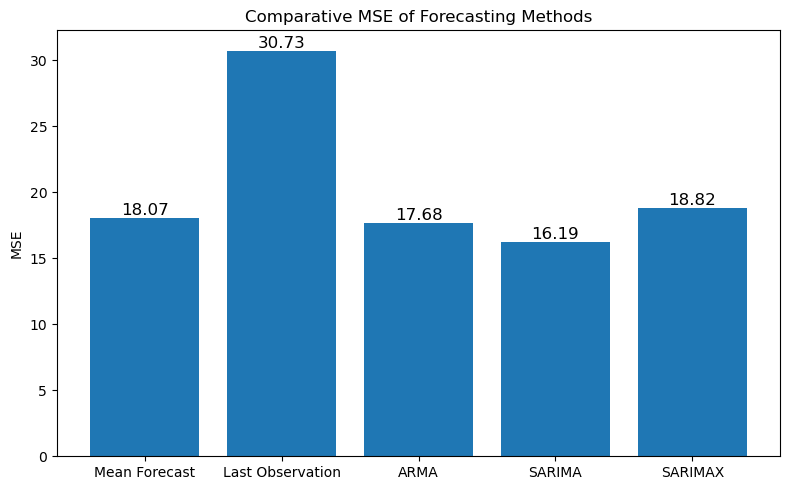

In [97]:
labels = ['Mean Forecast', 'Last Observation', 'ARMA', 'SARIMA', 'SARIMAX']
values = [mse_mean, mse_last, mse_ARMA, mse_SARIMA, mse_SARIMAX]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, values)

# Add value labels on top of bars
for bar, value in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{value:.2f}",
        ha='center',
        va='bottom',
        fontsize=12
    )

plt.ylabel("MSE")
plt.title("Comparative MSE of Forecasting Methods")
plt.tight_layout()
plt.show()

The **SARIMAX model performs worst than the SARIMA or the mean forecast**. 

Including Belgrade's rain data may not have been a good idea! This may be because the SARIMAX model requires us to forecast the exogenous variables too. Having to forecast an exogenous variable to forecast our target variable can magnify the prediction error of our target, meaning that our predictions can quickly degrade as we predict more timesteps into the future.

But we also have the **sales data for N05C - Psycholeptics drugs, Hypnotics and sedatives drugs**.
                                                                
Maybe each sales data series has an impact on the other? 
                                                                
Let's use a **VAR model** and see if the performance is better.

In [99]:
ts = df.set_index('datum')[["N05B","N05C"]].sort_index()

print("Number of time points:", len(ts))
ts.head()

Number of time points: 2106


,N05B,N05C
datum,,
2014-01-02,7.0,0.0
2014-01-03,16.0,0.0
2014-01-04,10.0,0.0
2014-01-05,8.0,0.0
2014-01-06,16.0,2.0


In [101]:
print(ts['N05C'].isna().sum())

0


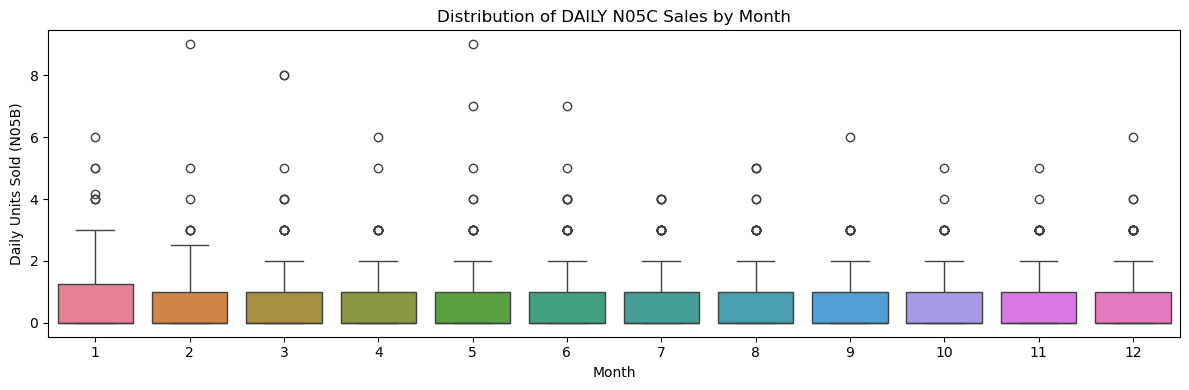

In [102]:
import seaborn as sns

# Create a Month column from the index
ts['Month'] = ts.index.month

# (Optional) ensure proper month ordering
ts['Month'] = pd.Categorical(
    ts['Month'],
    categories=[1,2,3,4,5,6,7,8,9,10,11,12],
    ordered=True
)

# Plot DAILY sales grouped by month
plt.figure(figsize=(12, 4))
sns.boxplot(data=ts, x='Month', y='N05C', palette='husl')

plt.title("Distribution of DAILY N05C Sales by Month")
plt.xlabel("Month")
plt.ylabel("Daily Units Sold (N05B)")
plt.tight_layout()
plt.show()

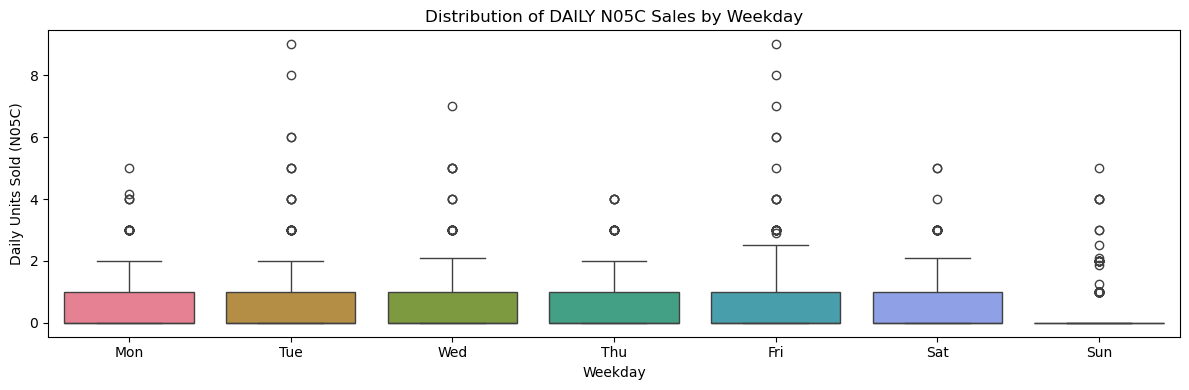

In [103]:
ts['Weekday'] = ts.index.weekday

# Map numbers to weekday names
weekday_map = {
    0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu',
    4: 'Fri', 5: 'Sat', 6: 'Sun'
}
ts['Weekday'] = ts['Weekday'].map(weekday_map)

# Set order (optional but nicer)
weekday_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Plot boxplot grouped by weekday
plt.figure(figsize=(12, 4))
sns.boxplot(data=ts, x='Weekday', y='N05C', order=weekday_order, palette='husl')

plt.title("Distribution of DAILY N05C Sales by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Daily Units Sold (N05C)")
plt.tight_layout()
plt.show()

We see more outliers here.

In [104]:
ts = ts.drop(['Month', 'Weekday'], axis=1)

TEST_HORIZON = 180   # e.g. last 180 days as test

ts_train = ts.iloc[:-TEST_HORIZON]
ts_test  = ts.iloc[-TEST_HORIZON:]

print("Train points:", len(ts_train))
print("Test points :", len(ts_test))

Train points: 1926
Test points : 180


In [107]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(ts_train.N05C)
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Number of lags used:", result[2])
print("Number of observations:", result[3])
print("Critical Values:", result[4])

ADF Statistic: -14.384021030938218
p-value: 9.052939757567338e-27
Number of lags used: 6
Number of observations: 1919
Critical Values: {'1%': np.float64(-3.4337622297208146), '5%': np.float64(-2.863047304445204), '10%': np.float64(-2.567572430319552)}


The ADF statistic is a negative number, and the p-value is much smaller than 0.05, so we can reject the null hypothesis and conclude that the N05C series is stationary.

In [109]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.varmax import VARMAX
def optimize_VAR(endog: Union[pd.Series, list]) -> pd.DataFrame:
    results = []
    for i in tqdm_notebook(range(15)):
        try:
            model = VARMAX(endog, order=(i, 0)).fit(dips=False)
        except:
            continue
        aic = model.aic
        results.append([i, aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['p', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [110]:
endog = ts[['N05B', 'N05C']]
train = ts[:180]
test = ts[180:]
result_df = optimize_VAR(train)
result_df

  0%|          | 0/15 [00:00<?, ?it/s]

,p,AIC
0,2,1618.996203
1,3,1619.745824
2,4,1624.256728
3,1,1625.905176
4,7,1629.648259
5,5,1629.920364
6,6,1635.582979
7,8,1636.594228
8,9,1643.199458
9,10,1648.498378


p = 2 has the lowest AIC value of all: the selected model is a VAR(3) model, meaning that the past two values of each time series are used to forecast the other time series.

In [113]:
from statsmodels.tsa.stattools import grangercausalitytests
print('realcons Granger-causes realdpi?\n')
print('------------------')
granger_1 = grangercausalitytests(ts[['N05B', 'N05C']].diff()[1:], [3])

print('\nrealdpi Granger-causes realcons?\n')
print('------------------')
granger_2 = grangercausalitytests(ts[['N05B', 'N05C']].diff()[1:], [3])

realcons Granger-causes realdpi?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8485  , p=0.1363  , df_denom=2095, df_num=3
ssr based chi2 test:   chi2=5.5640  , p=0.1349  , df=3
likelihood ratio test: chi2=5.5566  , p=0.1353  , df=3
parameter F test:         F=1.8485  , p=0.1363  , df_denom=2095, df_num=3

realdpi Granger-causes realcons?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8485  , p=0.1363  , df_denom=2095, df_num=3
ssr based chi2 test:   chi2=5.5640  , p=0.1349  , df=3
likelihood ratio test: chi2=5.5566  , p=0.1353  , df=3
parameter F test:         F=1.8485  , p=0.1363  , df_denom=2095, df_num=3


Running the Granger causality test for both variables returns a p-value larger than
0.05 in both cases. Therefore, we cannot reject the null hypothesis and conclude that
N05B Granger-causes N05C, and N05C Granger-causes N05B. Our
**VAR(2) model is invalid, and it cannot be used**. In that case, we must
use the SARIMAX model and predict each time series individually.

### References
* https://www.kaggle.com/code/milanzdravkovic/pharma-sales-data-analysis-and-forecasting/notebook
* Time Series Forecasting in Python, Marco Peixeiro. Manning. 2022